# Machine Learning for NLP

Now, we will explore how to use Machine Learning for data exploration through topic modelling. If you have a large number of documents, it's inefficient and time consuming to look at each and single one and bucket them to groups.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyLDAvis, pyLDAvis.sklearn

%matplotlib inline

In [2]:
df = pd.read_csv("./../assets/data_large.csv", index_col = 0)
print(f"Dataframe shape:\t{df.shape}")
df.head()

Dataframe shape:	(33727, 8)


,city,searched_zipcode,url,content,posting_date,education,n_photos,availability
0,ElPaso,79936,https://elpaso.craigslist.org/res/d/outbound-r...,"ASIDE FROM WORD OF MOUTH OR FACE TO FACE , COL...",2019-08-27 11:31,some college,0,['weekdays']
1,ElPaso,79936,https://elpaso.craigslist.org/res/d/best-resum...,Looking for a new job and no respond from the ...,2019-08-07 22:59,bachelors,0,['weekends']
2,ElPaso,79936,https://elpaso.craigslist.org/res/d/looking-fo...,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...,2019-08-17 08:25,bachelors,0,"['afternoons', 'evenings', 'mornings', 'weekda..."
3,ElPaso,79936,https://elpaso.craigslist.org/res/d/job-needed...,Well I'm a 24 year old female just lost my job...,2019-09-04 13:20,some college,1,"['evenings', 'mornings', 'overnight', 'weekday..."
4,ElPaso,79936,https://lascruces.craigslist.org/res/d/caregiv...,Caregiver available immediately. 5 years hospi...,2019-09-03 09:47,bachelors,0,"['afternoons', 'evenings', 'mornings', 'overni..."


Let's only keep the `content` column and remove any duplicate posts.

In [3]:
df = df[['content']]
df.drop_duplicates(subset = 'content', keep = 'first', inplace = True)
print(f"Dataframe shape:\t{df.shape}")
df.head()

Dataframe shape:	(11137, 1)


,content
0,"ASIDE FROM WORD OF MOUTH OR FACE TO FACE , COL..."
1,Looking for a new job and no respond from the ...
2,I DO BEST RESUMES IN TOWN.\r\n\r\nI AM TECHNIC...
3,Well I'm a 24 year old female just lost my job...
4,Caregiver available immediately. 5 years hospi...


## Topic Modelling
### Latent Dirichlet Allocation (LDA)
One of the popular ways of topic modelling is using LDA. LDA is an unsupervised algorithm that finds groups of words that contain the same set of words. Based on the words found in a group, humans can infer what the topic is of that group. The model uses a bag-of-words input so the sequence of words is ignored.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
# Create the bag of words model
count = CountVectorizer(analyzer = 'word',
                        stop_words = 'english',
                        max_features = 5000)

# Create the LDA model
lda = LatentDirichletAllocation(n_components = 20,
                                learning_method = 'online',
                                random_state = 20,
                                n_jobs = -1)

In [6]:
# Transform the text into bags of words
vect_data = count.fit_transform(df['content'])

In [7]:
# Fit the LDA model on our features
lda_data = lda.fit_transform(vect_data)

In [8]:
lda_data[:2]

array([[0.08172309, 0.59881077, 0.00102041, 0.00102041, 0.00102041,
        0.00102041, 0.00102041, 0.19500872, 0.00102041, 0.00102041,
        0.00102041, 0.10813088, 0.00102041, 0.00102041, 0.00102041,
        0.00102041, 0.00102041, 0.00102041, 0.00102041, 0.00102041],
       [0.28544794, 0.00238095, 0.00238095, 0.00238095, 0.00238095,
        0.00238095, 0.00238095, 0.00238095, 0.00238095, 0.47150154,
        0.00238095, 0.00238095, 0.20257433, 0.00238095, 0.00238095,
        0.00238095, 0.00238095, 0.00238095, 0.00238095, 0.00238095]])

Here we see the output of LDA. It's an M x N matrix where M is the number of documents and N is the number of groups. Each row corresponds to each document and the 20 features correspond to the 'likelihood' that the document is of that topic.

In [9]:
# Create dictionary of text features to bag-of-words index
text_2_idx = count.vocabulary_
idx_2_text = {idx:text for text, idx in text_2_idx.items()}

Now the model is fit to our data, we can get the words with the highest importance per group and transform it to words. We list out the first 10 words and from there, we can infer what the topic is per group.

In [10]:
topic_keyword_dict = {}
for topic_idx in range(lda_data.shape[1]):
    topic_keywords = []
    for word_idx in lda.components_[topic_idx].argsort()[::-1][:10]:
        topic_keywords.append(idx_2_text[word_idx])
    print(f"Topic {topic_idx}:\n\t{' '.join(topic_keywords)}")
    topic_keyword_dict[topic_idx] = ' '.join(topic_keywords)

Topic 0:
	customer skills service work team customers office ability company maintain
Topic 1:
	contact info services need help free email needs business phone
Topic 2:
	accounting accounts quickbooks financial payroll tax office bookkeeping bank credit
Topic 3:
	construction equipment shop production systems design hvac project parts quality
Topic 4:
	work repair contact info experience painting construction tools years installation
Topic 5:
	design marketing media social web website content digital designer graphic
Topic 6:
	com www contact https info en http al visit link
Topic 7:
	business management marketing development new real estate company il executive
Topic 8:
	lawn web traffic mobile engine developer search app website code
Topic 9:
	experience years work time looking resume position working seeking available
Topic 10:
	ca san 2017 2015 2016 2018 2014 education 2012 school
Topic 11:
	sales experience management manager customer recruiting years products new service
Topic 12

We can now infer the topic from each group. Going through the first few groups we find:<br>
- Customer Service
- Driving
- Construction
- Accounting

In [11]:
df['topic'] = [row.argsort()[-1] for row in lda_data]

In [12]:
df.loc[df['topic'] == 0].head()

,content,topic
6,Reliable well organized professional with stro...,0
18,** Bakers\r\n1. Job Knowledge: (1) Learn how t...,0
37,Gabriel Munoz- show contact info\r\n\r\nProfil...,0
45,Supervisor experience of multiple individuals ...,0
49,• Sales experience\r\n• Inbound/Outbound call ...,0


### pyLDAvis

In [13]:
# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization, be sure to sort_topics=False to keep the same order as above, that's important if we want to try and label
vis = pyLDAvis.sklearn.prepare(lda, vect_data, count, sort_topics=False, mds='mmds')

# Export as a standalone HTML web page
pyLDAvis.save_html(vis, 'lda_vis.html')

# Let's view it!
display(vis)

D:\Users\Prince\Anaconda3\envs\ds\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.036458  0.120618       1        1  10.571835
1      0.287487  0.069004       2        1   6.785799
2     -0.359975  0.055190       3        1   3.606463
3     -0.243675 -0.333985       4        1   3.833268
4      0.057026 -0.323666       5        1   7.677902
5     -0.238655 -0.168300       6        1   4.475175
6     -0.062170 -0.474385       7        1   1.103823
7     -0.165257  0.036788       8        1   6.136866
8      0.129364  0.486374       9        1   0.977742
9      0.141922 -0.041970      10        1  11.843691
10     0.228437 -0.381668      11        1   5.985179
11     0.013110  0.303212      12        1   3.813418
12     0.421384  0.045673      13        1   9.773117
13    -0.157041  0.379648      14        1   3.528643
14     0.346378  0.303458      15        1   2.110342
15    -0.207506  0.227074      16        1   5.132785
16    -0.483082 -0.182643      17        1   1.509175
17    -0.416043  0.225213      18        1   2.895325
18     0.420065 -0.170162      19        1   2.154642
19     0.251775 -0.175473      20        1   6.084808, topic_info=     Category         Freq            Term        Total  loglift  logprob
3937  Default  2769.000000           sales  2769.000000  30.0000  30.0000
1070  Default  4851.000000         contact  4851.000000  29.0000  29.0000
761   Default  1977.000000            care  1977.000000  28.0000  28.0000
2670  Default  5559.000000         looking  5559.000000  27.0000  27.0000
4943  Default  9595.000000            work  9595.000000  26.0000  26.0000
2306  Default  2906.000000            info  2906.000000  25.0000  25.0000
2756  Default  2021.000000       marketing  2021.000000  24.0000  24.0000
893   Default  1477.000000        cleaning  1477.000000  23.0000  23.0000
708   Default  3535.000000        business  3535.000000  22.0000  22.0000
715   Default  1617.000000              ca  1617.000000  21.0000  21.0000
2983  Default  3022.000000            need  3022.000000  20.0000  20.0000
953   Default   946.000000             com   946.000000  19.0000  19.0000
1317  Default  1573.000000          design  1573.000000  18.0000  18.0000
2730  Default  3287.000000      management  3287.000000  17.0000  17.0000
178   Default   982.000000      accounting   982.000000  16.0000  16.0000
1207  Default  2305.000000        customer  2305.000000  15.0000  15.0000
2134  Default  2612.000000            help  2612.000000  14.0000  14.0000
2446  Default  3712.000000             job  3712.000000  13.0000  13.0000
2171  Default  2483.000000            home  2483.000000  12.0000  12.0000
3063  Default  2566.000000          office  2566.000000  11.0000  11.0000
12    Default  1521.000000              10  1521.000000  10.0000  10.0000
4986  Default  4794.000000           years  4794.000000   9.0000   9.0000
1061  Default  1496.000000    construction  1496.000000   8.0000   8.0000
2803  Default   895.000000           media   895.000000   7.0000   7.0000
179   Default   995.000000        accounts   995.000000   6.0000   6.0000
3978  Default  1230.000000          school  1230.000000   5.0000   5.0000
3776  Default  1115.000000          repair  1115.000000   4.0000   4.0000
1717  Default  6890.000000      experience  6890.000000   3.0000   3.0000
3271  Default  1105.000000        personal  1105.000000   2.0000   2.0000
4176  Default  1041.000000        software  1041.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
1169  Topic20   197.127824             cpr   216.493456   2.7057  -5.4027
1474  Topic20   699.126723          driver   843.649954   2.6115  -4.1367
1854  Topic20    67.198923         flatbed    70.459991   2.7520  -6.4789
4532  Topic20    89.861961         therapy    97.110118   2.7218  -6.1883
2205  Topic20   239.154197    housekeeping   299.111484   2.5757  -5.2094
2596  Topic20   435.216794     

## TSNE
LDA gives us a distribution of topic per document. However, it's difficult to actually compare each documents other than getting the topic for each document and using that to represent it. Here, we will explore t-SNE which is a dimension reduction algorithm. It's a great method to reduce data from multidimensions (in our case 20 topics) to less features so we can visualize it. That way, we not only see the groups of resumes, but also see the relationship of groups with each other.

In [14]:
from sklearn.manifold import TSNE

In [15]:
# Create the TSNE model
# Note that cosine is typically used for bag-of-words
# model similarity because of how it works with long and short documents
tsne = TSNE(n_components = 2,
            metric = 'cosine',
            verbose = 1,
            random_state = 42)

In [16]:
# Fit the t-SNE model
tsne_feature = tsne.fit_transform(lda_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11137 samples in 0.000s...
[t-SNE] Computed neighbors for 11137 samples in 2.477s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11137
[t-SNE] Computed conditional probabilities for sample 2000 / 11137
[t-SNE] Computed conditional probabilities for sample 3000 / 11137
[t-SNE] Computed conditional probabilities for sample 4000 / 11137
[t-SNE] Computed conditional probabilities for sample 5000 / 11137
[t-SNE] Computed conditional probabilities for sample 6000 / 11137
[t-SNE] Computed conditional probabilities for sample 7000 / 11137
[t-SNE] Computed conditional probabilities for sample 8000 / 11137
[t-SNE] Computed conditional probabilities for sample 9000 / 11137
[t-SNE] Computed conditional probabilities for sample 10000 / 11137
[t-SNE] Computed conditional probabilities for sample 11000 / 11137
[t-SNE] Computed conditional probabilities for sample 11137 / 11137
[t-SNE] Mean sigma: 0.019218
[t-SNE] KL divergence

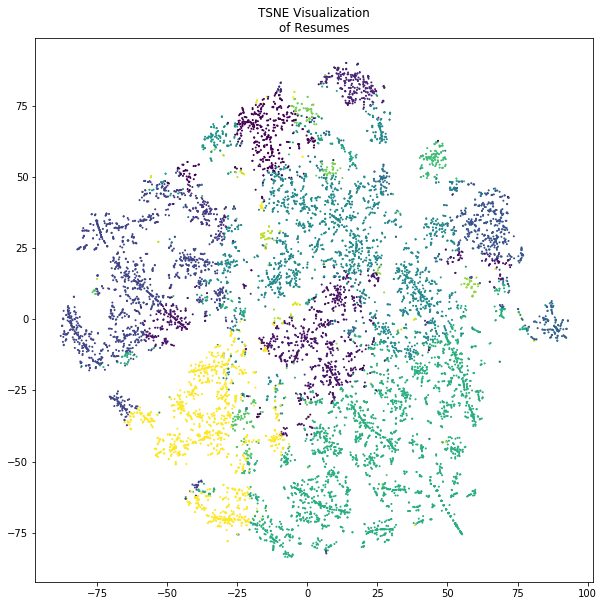

In [17]:
plt.figure(figsize = (10, 10))
plt.scatter(tsne_feature[:,0], tsne_feature[:,1], 
            s = 1, c = df['topic'])
plt.title("TSNE Visualization\nof Resumes")
plt.show()

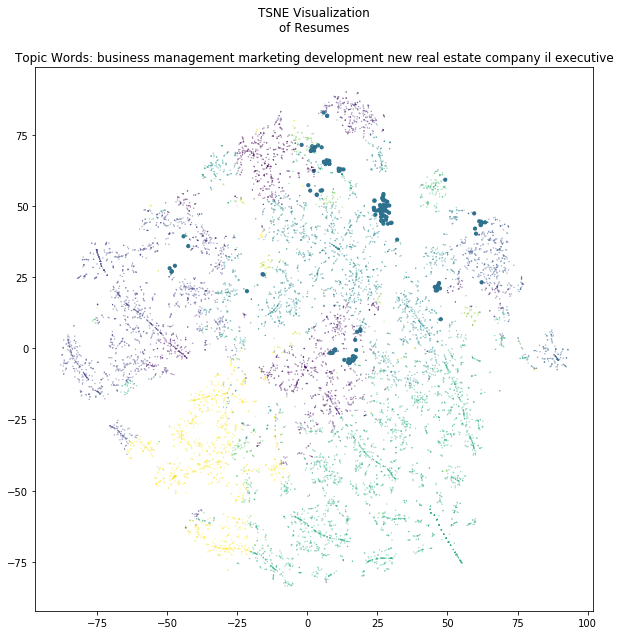

In [18]:
highlight_topic = 7
sizes = [10 if a == highlight_topic else 0.05 for a in df['topic']]
plt.figure(figsize = (10, 10))
plt.scatter(tsne_feature[:,0], tsne_feature[:,1], 
            s = sizes, c = df['topic'])
plt.title(f"TSNE Visualization\nof Resumes\n\nTopic Words: {topic_keyword_dict[highlight_topic]}")
plt.show()